# Single neuron Calcium Imaging

This notebook has the code to extract Calcium traces from the single neuron recordings on ZIM01.

In [1]:
#Unet
#import pckgs
import cv2
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re
from numpy import unravel_index
import os
from natsort import natsorted
from imutils.src import imfunctions
import glob
from pathlib import Path
import shutil
import single_cell_imaging_functions as ca_image

Using TensorFlow backend.


### Option 1: Binarize using make_contour based binary

In [2]:
input_filepath='/scratch/zimmer/DanielM/zim01/BAG_RFP_max/2021-07-08_15-48-52_worm1_onfood-channel-0rfp_raw.btf'
output_filepath='/scratch/zimmer/DanielM/zim01/BAG_RFP_max/2021-07-08_15-48-52_worm1_onfood-channel-0rfp_raw_binary.btf'
median_blur=3
lt=140
ht=255
contour_size=2000
tolerance=0.5
area_to_fill=100
imfunctions.make_contour_based_binary(input_filepath, output_filepath, median_blur, lt, ht, contour_size, tolerance, area_to_fill)

In [3]:
#To check what areas the contour size and tolerance parameters give:
contour_size=500
tolerance=0.5
print(contour_size*(1-tolerance))
print(contour_size*(1+tolerance))

250.0
750.0


### Option 2: Binarize only with blur and threshold

In [4]:
input_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-0-Andor3972bigtiff.btf'
output_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-0-Andor3972bigtiff_binary.btf'
median_blur=3
lower_threshold=2000
higher_threshold=255
ca_image.binarize_btf(input_filepath,output_filepath,median_blur,lower_threshold,higher_threshold)

## option 1 for all worms

In [8]:
#apply the binarization
input_filepath=Path(r'/scratch/zimmer/DanielM/ZIM443_RFP_max/')
output_path=Path(r'/scratch/zimmer/DanielM/ZIM443_RFP_max/')
median_blur=3
lt=140
ht=255
for input_file in input_filepath.glob('*.btf'):
    
    
    
    outputpath_filename=f'{output_path}/{input_file.stem}_binary.btf'
    
    
    
    ca_image.binarize_btf(input_file,outputpath_filename,median_blur,lower_threshold,higher_threshold)
print('done')

done


### Transform GCAMP Channel if needed
This will transform the GCAMP Channel in case the camera alignment was not good.

In [9]:
gcamp_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-1-Andor9046bigtiff_subsampled.btf'
output_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-1-Andor9046bigtiff_subsampled_wrongly_transformed.btf'

In [ ]:
with tiff.TiffWriter(output_filepath, bigtiff=True) as tif_writer,\
    tiff.TiffFile(gcamp_filepath, multifile=False) as tif_gcamp:
    
    for i, page in enumerate(tif_gcamp.pages):
        
        img=page.asarray()
        
        #create the transformation matrix 
        M = np.float32([[1, 0, -50], [0, 1, 10]])
        
        #transform it based on the transformation matrix
        shifted = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        
        #flip if needed
        flipped = cv2.flip(shifted, 1)
        
        #save the processed Gcamp channel
        tif_writer.write(shifted, contiguous=True)

### calculate background intensity

In [10]:
rfp_mask_filepath='/scratch/zimmer/DanielM/zim01/BAG_RFP_max/binary/2021-07-20_15-13-27_bagworm3_on-channel-0rfp_raw_binary.btf'
gcamp_filepath='/scratch/zimmer/DanielM/zim01/BAG_GFP_max/BAG_GFP_MAX_CORRECTED/2021-07-20_15-13-27_bagworm3_on-channel-1.btf'
rfp_filepath='/scratch/zimmer/DanielM/zim01/BAG_RFP_max/2021-07-20_15-13-27_bagworm3_on-channel-0rfp_raw.btf'

#### for red channel

In [11]:
with tiff.TiffFile(rfp_mask_filepath, multifile=True) as tif_mask,\
        tiff.TiffFile(rfp_filepath, multifile=False) as tif_fluorescence:
    
        steps=int(len(tif_mask.pages)*0.01)
    
        for i, page in enumerate(tif_mask.pages):
            
            mask=tif_mask.pages[i].asarray()
            flourescence=tif_fluorescence.pages[i].asarray()
            
            if i %steps==0:
                
                rfp_background=ca_image.calculate_background(mask,flourescence)

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  """Entry point for launching an IPython kernel.
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  


#### for green channel

In [12]:
with tiff.TiffFile(rfp_mask_filepath, multifile=True) as tif_mask,\
        tiff.TiffFile(gcamp_filepath, multifile=False) as tif_fluorescence:
    
        steps=int(len(tif_mask.pages)*0.01)
    
        for i, page in enumerate(tif_mask.pages):
            
            mask=tif_mask.pages[i].asarray()
            fluorescence=tif_fluorescence.pages[i].asarray()
            
            if i %steps==0:
                
                gfp_background=ca_image.calculate_background(mask,fluorescence)

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  """Entry point for launching an IPython kernel.
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  


### calculate signal

#### for red channel

In [13]:
fluorescence_signal=[]
with tiff.TiffFile(rfp_mask_filepath, multifile=True) as tif_mask,\
    tiff.TiffFile(rfp_filepath, multifile=False) as tif_fluorescence:
    
    
    for i, page in enumerate(tif_fluorescence.pages):
    
        
            
        mask=tif_mask.pages[i].asarray()
        fluorescence=tif_fluorescence.pages[i].asarray()
            
        rfp=ca_image.calculate_signal(mask,fluorescence)
        
        fluorescence_signal.append(rfp)


rfp_background_corrected=np.array(fluorescence_signal.copy())-rfp_background

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  This is separate from the ipykernel package so we can avoid doing imports until
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### for green channel

In [14]:
fluorescence_signal=[]

with tiff.TiffFile(rfp_mask_filepath, multifile=True) as tif_mask,\
    tiff.TiffFile(gcamp_filepath, multifile=False) as tif_fluorescence:
    
    
    for i, page in enumerate(tif_fluorescence.pages):
        
        mask=tif_mask.pages[i].asarray()
        fluorescence=tif_fluorescence.pages[i].asarray()
            
        gfp=ca_image.calculate_signal(mask,fluorescence)
        
        fluorescence_signal.append(gfp)

gfp_background_corrected=np.array(fluorescence_signal.copy())-gfp_background


/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  This is separate from the ipykernel package so we can avoid doing imports until
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  after removing the cwd from sys.path.


### calculate ratiometric signal

### plot the ratiometric signal

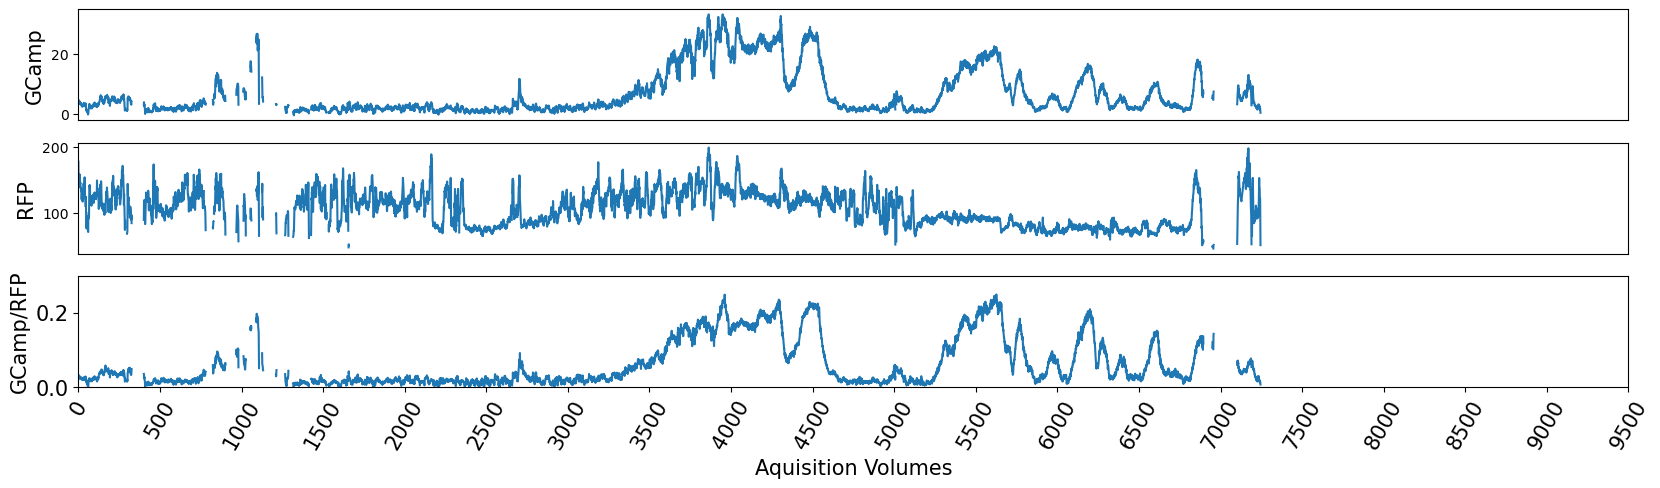

In [15]:
#plot signal
axes=ca_image.plot_gcamp_rfp_ratio(gfp_background_corrected,rfp_background_corrected)

#some modifications to the plot

for i,ax in enumerate(axes):
    ax.set_xlim([0, 9500])
    if i<2: 
        ax.set_xticks([])
        plt.yticks(fontsize=15)
    
    if i==2:
        ax.tick_params(axis='x', labelrotation = 60)
        ax.xaxis.set_ticks(np.arange(0, len(gfp_background_corrected), 500))
        ax.set_ylim([0, 0.3])
        ax.set_xlabel('Aquisition Volumes',fontsize=15)
        ax.set_xlim([0, 9500])
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        ax.tick_params(axis="x", labelsize=15)
        ax.tick_params(axis="y", labelsize=15)

### save the ratiometric signal as a csv

In [ ]:
ratiometric_signal=gfp/rfp
df=pd.DataFrame(ratiometric_signal)
#df.to_csv('/scratch/zimmer/DanielM/ratiometric_bagworm3.csv', index=None)
#df.plot()

### plot the ratiometric signal for all recordings

##### here i make lists containing paths to corresponding mask, rfp and gfp files

In [16]:
#make list of rfp path

rfp_path=Path(r'/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_RFP_max/')

rfp_path_list=[]
for file in natsorted(os.listdir(rfp_path)):
     if file.endswith('raw.btf'):
        rfp_filepath=f'{rfp_path}/{file}'
        rfp_path_list.append(rfp_filepath)


In [17]:
#make list of gfp path
gcamp_path=Path(r'/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_GFP_max/transformed/')
gcamp_path_list=[]
for file in natsorted(os.listdir(gcamp_path)):
     if file.endswith('.btf'):
        gcamp_filepath=f'{gcamp_path}/{file}'
        gcamp_path_list.append(gcamp_filepath)

In [18]:
#make list of rfp_mask path
rfp_path_mask=Path(r'/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_RFP_max/binary/')
rfp_path_mask_list=[]
for file in natsorted(os.listdir(rfp_path_mask)):
     if file.endswith('.btf'):
            mask_rfp_filepath=f'{rfp_path_mask}/{file}'
            rfp_path_mask_list.append(mask_rfp_filepath)
            
            

In [19]:
rfp_path_mask_list

['/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_RFP_max/binary/2021-07-15_14-27-22_zim443_wor2_on-channel-0rfp_raw_binary.btf',
 '/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_RFP_max/binary/2021-07-15_15-12-30_zim443_wor3_on-channel-0rfp_raw_binary.btf',
 '/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_RFP_max/binary/2021-07-15_16-49-36_zim443_wor4_on-channel-0rfp_raw_binary.btf',
 '/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_RFP_max/binary/2021-07-15_17-14-13_zim443_wor5_off-channel-0rfp_raw_binary.btf']

In [20]:
gcamp_path_list

['/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_GFP_max/transformed/2021-07-15_14-27-22_zim443_wor2_on-channel-1rfp_raw.btf',
 '/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_GFP_max/transformed/2021-07-15_15-12-30_zim443_wor3_on-channel-1rfp_raw.btf',
 '/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_GFP_max/transformed/2021-07-15_16-49-36_zim443_wor4_on-channel-1rfp_raw.btf',
 '/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_GFP_max/transformed/2021-07-15_17-14-13_zim443_wor5_off-channel-1rfp_raw.btf']

In [21]:
rfp_path_list

['/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_RFP_max/2021-07-15_14-27-22_zim443_wor2_on-channel-0rfp_raw.btf',
 '/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_RFP_max/2021-07-15_15-12-30_zim443_wor3_on-channel-0rfp_raw.btf',
 '/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_RFP_max/2021-07-15_16-49-36_zim443_wor4_on-channel-0rfp_raw.btf',
 '/scratch/zimmer/DanielM/zim01/zim_443_urx/ZIM443_RFP_max/2021-07-15_17-14-13_zim443_wor5_off-channel-0rfp_raw.btf']

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


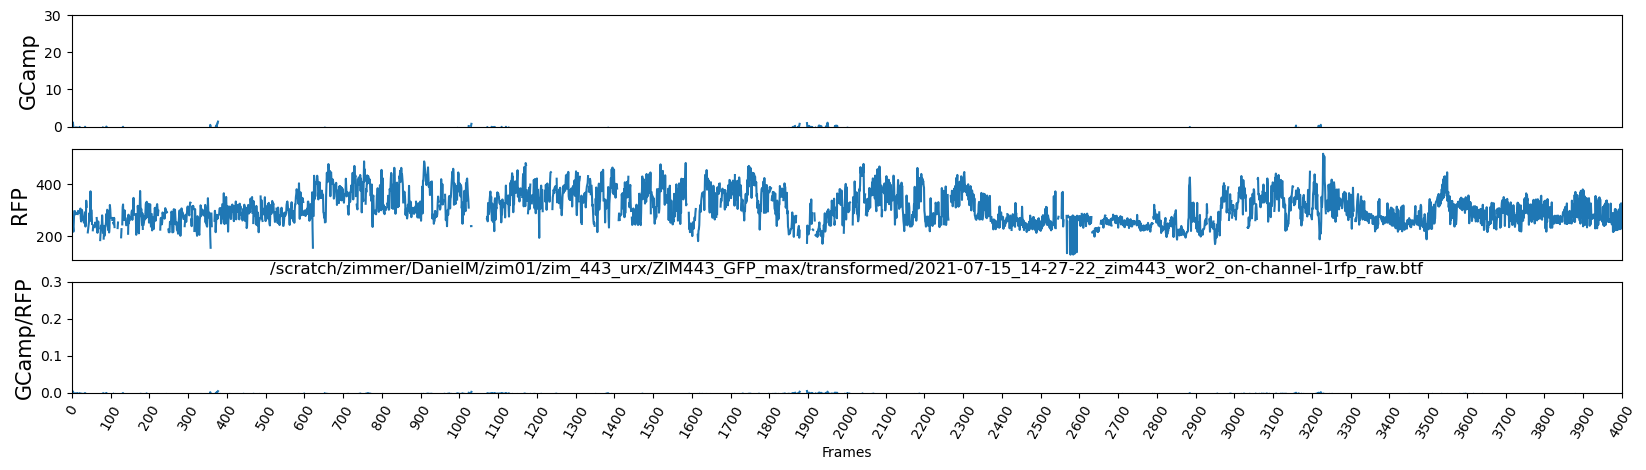

In [22]:
for idx in range(len(gcamp_path_list)-1):
    
    #get paths
    
    gcamp_filepath=gcamp_path_list[idx]
    rfp_filepath=rfp_path_list[idx]
    rfp_mask_filepath=rfp_path_mask_list[idx]
    
    #calculate background intensity
    background_gfp,background_rfp=ca_image.calculate_background_2(rfp_mask_filepath,rfp_filepath,gcamp_filepath)
    
    #calculate signal
    gcamp_signal, rfp_signal=ca_image.calculate_signal_2(rfp_mask_filepath,rfp_filepath,gcamp_filepath,background_gfp,background_rfp)
    
    #plot
    axes=ca_image.plot_gcamp_rfp_ratio(gcamp_signal,rfp_signal)

    #some modifications to the plot
    axes[0].set_ylim([0,30])
    for i,ax in enumerate(axes):
        ax.set_xlim([0, 4000])
        if i<2: 
            ax.set_xticks([])
        if i==2:
            ax.tick_params(axis='x', labelrotation = 60)
            ax.xaxis.set_ticks(np.arange(0, len(gcamp_signal), 100))
            ax.set_ylim([0, 0.3])
            ax.set_xlabel('Frames')
    plt.title(gcamp_path_list[idx])
    break

In [63]:
gcamp_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-0-Andor3972bigtiff_subsampled.btf'
rfp_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-1-Andor9046bigtiff_subsampled_wrongly_transformed.btf'

In [ ]:
plt.hist(gcamp[roi])
plt.hist(gcamp[roi2])

(array([38., 34., 26., 23., 17.,  4.,  0.,  1.,  0.,  1.]),
 array([301. , 320.6, 340.2, 359.8, 379.4, 399. , 418.6, 438.2, 457.8,
        477.4, 497. ]),
 <a list of 10 Patch objects>)

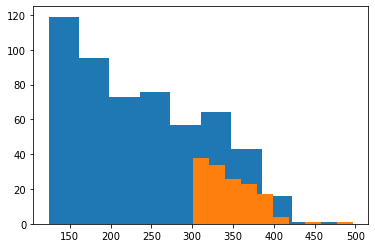

In [162]:
plt.hist(rfp[roi])
plt.hist(rfp[roi2])


In [157]:
#convert list to numpy array
gcamp_signal=np.array(gcamp_signal)
rfp_signal=np.array(rfp_signal)


In [40]:
#remove background (TODO: improve background calculation)
gcamp_signal=gcamp_signal-104
rfp_signal=rfp_signal-104

In [76]:
#find frames where there is no signal
np.where(np.isnan(gcamp_signal))

(array([ 288,  289,  290, ..., 9980, 9981, 9982]),)

In [77]:
#check % of frames without signal
np.isnan(gcamp_signal).sum()/gcamp_signal.shape[0]

0.3439847741159972

### Stack Subsampling

For instance the behaviour to have same number of frames as max projections (default is number of frames == total number of planes)

In [41]:
input_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-1-Andor9046bigtiff.btf'
output_filepath='/scratch/zimmer/DanielM/bag_zim_06/9.9/2021-09-06bag_zim06/btiffs/2021-09-06_19-05-32_worm4_on-channel-1-Andor9046bigtiff_subsampled.btf'
with tiff.TiffFile(input_filepath, multifile=False) as tif,\
 tiff.TiffWriter(output_filepath, bigtiff=True) as tif_writer:
    for i, page in enumerate(tif.pages):
        if i %6==0:
            img=page.asarray()
            tif_writer.write(img,contiguous=True)
            

/users/daniel.mitic/.conda/envs/openCV/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: TiffFile: the 'multifile' argument is ignored
  This is separate from the ipykernel package so we can avoid doing imports until
